In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import tensorflow as tf

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Simple demo neural network classifier:

In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

num_classes = 2

def build_classifier(num_classes, num_dimensions=1781):

    classifier = Sequential([
        Dense(1024, activation='relu', input_shape=(num_dimensions, )),
        Dense(128, activation='relu'),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    classifier.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy',])
    return classifier

In [4]:
import numpy as np

with open("ref_data/SRR_47normal_small.list") as normal_subjects_file:
    healthy_subjects = [line.strip() for line in normal_subjects_file]

with open("ref_data/SRR_50aml_small.list") as diseased_subjects_file:
    diseased_subjects = [line.strip() for line in diseased_subjects_file]

In [5]:
print(len(healthy_subjects), len(diseased_subjects))

47 50


In [6]:
def load_data(subjects_array, subdirectory="test_data/test_counts/"):
    a = []
    for person in subjects_array:
        try:
            with open(subdirectory + person + ".count") as person_file:
                vector = [line.strip().split()[-1] for line in person_file]
                a.append(np.array(vector))
        except FileNotFoundError:
            continue
    return a

X_healthy = load_data(healthy_subjects)
y_healthy = [0. for _ in range(len(X_healthy))]
X_diseased = load_data(diseased_subjects)
y_diseased = [1. for _ in range(len(X_diseased))]

In [7]:
print(len(X_healthy), len(X_diseased))
print(len(y_healthy), len(y_diseased))

30 47
30 47


In [11]:
num_test_per_class = 2

X = np.array(X_healthy[:-num_test_per_class] + X_diseased[:-num_test_per_class])
y = np.array(y_healthy[:-num_test_per_class] + y_diseased[:-num_test_per_class])

X_test = np.array(X_healthy[-num_test_per_class:] + X_diseased[-num_test_per_class:])
y_test = np.array(y_healthy[-num_test_per_class:] + y_diseased[-num_test_per_class:])

In [12]:
num_people = len(X)

One-Hot Encode Output Labels:

In [13]:
from tensorflow.python.keras.utils import to_categorical

y1hot = to_categorical(y, num_classes=num_classes)

## K-Fold Cross Validation
Since we don't have many people represented in our data, we'll do leave-one-out cross validation:

In [14]:
from sklearn.model_selection import KFold
from tensorflow.python.keras.callbacks import ModelCheckpoint

kf = KFold(n_splits=num_people)
fold_number = 1
cvscores = []
for train_index, val_index in kf.split(X):
    print("Fold " + str(fold_number))
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y1hot[train_index], y1hot[val_index]
    classifier = build_classifier(num_classes=num_classes)
    filename = "fold{}.weights.hdf5".format(fold_number)
    model_checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
    classifier.fit(X_train, y_train, batch_size=num_people, epochs=8, validation_data=(X_val, y_val), verbose=2, callbacks=[model_checkpointer])
    classifier.load_weights(filename)
    scores = classifier.evaluate(X_val, y_val, verbose=0)
    print(classifier.metrics_names)
    print(scores)
    cvscores.append(scores)
    del classifier
    fold_number += 1

Fold 1
Train on 72 samples, validate on 1 samples
Epoch 1/8
 - 1s - loss: 1.5927 - acc: 0.2500 - val_loss: 0.4524 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.45240, saving model to fold1.weights.hdf5
Epoch 2/8
 - 0s - loss: 0.4663 - acc: 0.7500 - val_loss: 1.2854 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 1.4156 - acc: 0.6250 - val_loss: 0.4420 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.45240 to 0.44198, saving model to fold1.weights.hdf5
Epoch 4/8
 - 0s - loss: 0.0585 - acc: 0.9722 - val_loss: 0.1278 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.44198 to 0.12783, saving model to fold1.weights.hdf5
Epoch 5/8
 - 0s - loss: 0.2931 - acc: 0.9444 - val_loss: 0.0660 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.12783 to 0.06596, saving model to fold1.weights.hdf5
Epoch 6/8
 - 0s - loss: 0.5812 - acc: 0.8611 - val_loss: 0.0695 - val_acc: 1.0000

Epoch 00006: val_loss did not improve
Epoch 7/8
 -


Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 0.1957 - acc: 0.9583 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 1.9383 - acc: 0.6389 - val_loss: 6.7422 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 0.6739 - acc: 0.6389 - val_loss: 1.7099 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 0.5538 - acc: 0.6389 - val_loss: 0.8163 - val_acc: 0.0000e+00

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 0.3460 - acc: 0.6528 - val_loss: 5.5505 - val_acc: 0.0000e+00

Epoch 00008: val_loss did not improve
['loss', 'acc']
[1.1920930376163597e-07, 1.0]
Fold 8
Train on 72 samples, validate on 1 samples
Epoch 1/8
 - 1s - loss: 7.6052 - acc: 0.3750 - val_loss: 2.3842e-07 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to fold8.weights.hdf5
Epoch 2/8
 - 0s - loss: 1.7335 - acc: 0.3889 - val_loss: 16.1181 


Epoch 00001: val_loss improved from inf to 16.11810, saving model to fold14.weights.hdf5
Epoch 2/8
 - 0s - loss: 2.7399 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 2.4950 - acc: 0.6250 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 2.2328 - acc: 0.6389 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 2.1881 - acc: 0.8056 - val_loss: 3.2820 - val_acc: 0.0000e+00

Epoch 00005: val_loss improved from 16.11810 to 3.28199, saving model to fold14.weights.hdf5
Epoch 6/8
 - 0s - loss: 0.3109 - acc: 0.8889 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00006: val_loss improved from 3.28199 to 0.00000, saving model to fold14.weights.hdf5
Epoch 7/8
 - 0s - loss: 2.7992 - acc: 0.3889 - val_loss: 2.3842e-07 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 0.6111 - acc: 0.5556 - v

Epoch 5/8
 - 0s - loss: 1.2252 - acc: 0.8472 - val_loss: 0.0621 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.35299 to 0.06211, saving model to fold20.weights.hdf5
Epoch 6/8
 - 0s - loss: 5.8730 - acc: 0.3750 - val_loss: 0.0601 - val_acc: 1.0000

Epoch 00006: val_loss improved from 0.06211 to 0.06013, saving model to fold20.weights.hdf5
Epoch 7/8
 - 0s - loss: 1.5465 - acc: 0.5556 - val_loss: 0.0933 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 2.0489 - acc: 0.8611 - val_loss: 0.1482 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[0.06013159081339836, 1.0]
Fold 21
Train on 72 samples, validate on 1 samples
Epoch 1/8
 - 1s - loss: 1.0211 - acc: 0.2361 - val_loss: 0.6827 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.68268, saving model to fold21.weights.hdf5
Epoch 2/8
 - 0s - loss: 0.6431 - acc: 0.7639 - val_loss: 0.6977 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - 

 - 0s - loss: 0.0606 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 1.0000

Epoch 00008: val_loss improved from 0.06975 to 0.03440, saving model to fold26.weights.hdf5
['loss', 'acc']
[0.03439664840698242, 1.0]
Fold 27
Train on 72 samples, validate on 1 samples
Epoch 1/8
 - 2s - loss: 1.2731 - acc: 0.3889 - val_loss: 4.2884 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 4.28841, saving model to fold27.weights.hdf5
Epoch 2/8
 - 0s - loss: 3.2506 - acc: 0.6250 - val_loss: 3.1861 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 4.28841 to 3.18608, saving model to fold27.weights.hdf5
Epoch 3/8
 - 0s - loss: 3.0522 - acc: 0.6250 - val_loss: 2.0813 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 3.18608 to 2.08134, saving model to fold27.weights.hdf5
Epoch 4/8
 - 0s - loss: 2.8364 - acc: 0.6250 - val_loss: 1.0484 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 2.08134 to 1.04843, saving model to fold27.weights.hdf5
Epoch 5/8
 - 0s - loss: 2.573

Epoch 2/8
 - 0s - loss: 1.2169 - acc: 0.5278 - val_loss: 0.0061 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.92120 to 0.00611, saving model to fold33.weights.hdf5
Epoch 3/8
 - 0s - loss: 2.3008 - acc: 0.7083 - val_loss: 0.0386 - val_acc: 1.0000

Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 0.5595 - acc: 0.7917 - val_loss: 0.0729 - val_acc: 1.0000

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 0.6007 - acc: 0.5972 - val_loss: 0.0153 - val_acc: 1.0000

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 0.2276 - acc: 0.9306 - val_loss: 0.0027 - val_acc: 1.0000

Epoch 00006: val_loss improved from 0.00611 to 0.00267, saving model to fold33.weights.hdf5
Epoch 7/8
 - 0s - loss: 0.9884 - acc: 0.7639 - val_loss: 0.0155 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 0.3989 - acc: 0.7917 - val_loss: 0.0157 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[0.002672066679224372, 1.0]
F


Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 2.2676 - acc: 0.8611 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 1.4510 - acc: 0.8889 - val_loss: 4.1723e-06 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[1.1920930376163597e-07, 1.0]
Fold 40
Train on 72 samples, validate on 1 samples
Epoch 1/8
 - 2s - loss: 1.1753 - acc: 0.5972 - val_loss: 1.5850 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.58499, saving model to fold40.weights.hdf5
Epoch 2/8
 - 0s - loss: 5.4123 - acc: 0.3750 - val_loss: 3.3379e-05 - val_acc: 1.0000

Epoch 00002: val_loss improved from 1.58499 to 0.00003, saving model to fold40.weights.hdf5
Epoch 3/8
 - 0s - loss: 0.1186 - acc: 0.9583 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00003 to 0.00000, saving model to fold40.weights.hdf5
Epoch 4/8
 - 0s - loss: 2.5693 - acc: 0.7222 - val_loss: 1.1921e-07 - val_acc: 1.


Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 1.0640 - acc: 0.6944 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 0.0253 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 0.0233 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 0.0277 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 0.4350 - acc: 0.9583 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[1.1920930376163597e-07, 1.0]
Fold 47
Train on 72 samples, validate on 1 samples
Epoch 1/8
 - 3s - loss: 1.7244 - acc: 0.2500 - val_loss: 10.0304 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 10.03044, saving model to fold47.weights.hdf5
Epoch 2/8
 - 0s - loss: 1.8541 - acc: 0.4861 - val_loss: 0.006

Epoch 2/8
 - 0s - loss: 2.6852 - acc: 0.3889 - val_loss: 1.4468 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 5.23744 to 1.44682, saving model to fold53.weights.hdf5
Epoch 3/8
 - 0s - loss: 0.9444 - acc: 0.4583 - val_loss: 0.0018 - val_acc: 1.0000

Epoch 00003: val_loss improved from 1.44682 to 0.00179, saving model to fold53.weights.hdf5
Epoch 4/8
 - 0s - loss: 1.4668 - acc: 0.6667 - val_loss: 0.0115 - val_acc: 1.0000

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 0.4767 - acc: 0.7361 - val_loss: 0.0957 - val_acc: 1.0000

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 0.2171 - acc: 1.0000 - val_loss: 0.2433 - val_acc: 1.0000

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 0.2986 - acc: 0.9028 - val_loss: 0.0607 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 0.1818 - acc: 0.9722 - val_loss: 0.0033 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[0.0017936809454113245, 1

Train on 72 samples, validate on 1 samples
Epoch 1/8
 - 4s - loss: 0.8745 - acc: 0.7222 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 16.11810, saving model to fold60.weights.hdf5
Epoch 2/8
 - 0s - loss: 7.4707 - acc: 0.3889 - val_loss: 1.8537 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 16.11810 to 1.85374, saving model to fold60.weights.hdf5
Epoch 3/8
 - 0s - loss: 1.1177 - acc: 0.6806 - val_loss: 1.9491e-05 - val_acc: 1.0000

Epoch 00003: val_loss improved from 1.85374 to 0.00002, saving model to fold60.weights.hdf5
Epoch 4/8
 - 0s - loss: 2.3326 - acc: 0.6389 - val_loss: 1.5123e-04 - val_acc: 1.0000

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 1.1513 - acc: 0.6667 - val_loss: 0.0075 - val_acc: 1.0000

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 0.1513 - acc: 0.9722 - val_loss: 0.0655 - val_acc: 1.0000

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 0.2952 - acc: 0.9167 - val_los


Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 0.5231 - acc: 0.6111 - val_loss: 0.1166 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 0.4436 - acc: 0.6111 - val_loss: 0.0096 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[0.00013525209215003997, 1.0]
Fold 67
Train on 72 samples, validate on 1 samples
Epoch 1/8
 - 4s - loss: 0.8593 - acc: 0.6250 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to fold67.weights.hdf5
Epoch 2/8
 - 0s - loss: 2.5667 - acc: 0.6250 - val_loss: 0.0110 - val_acc: 1.0000

Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 0.1691 - acc: 0.9722 - val_loss: 0.0015 - val_acc: 1.0000

Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 0.0619 - acc: 0.9861 - val_loss: 1.1921e-06 - val_acc: 1.0000

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 0.0311 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1


Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 0.5948 - acc: 0.7917 - val_loss: 1.0419e-04 - val_acc: 1.0000

Epoch 00006: val_loss improved from 0.00031 to 0.00010, saving model to fold73.weights.hdf5
Epoch 7/8
 - 0s - loss: 0.4632 - acc: 0.7917 - val_loss: 2.6838e-04 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 0.3498 - acc: 0.7917 - val_loss: 3.1190e-04 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[0.000104194346931763, 1.0]


In [15]:
accuracies = np.array(cvscores)[:, 1]

In [16]:
print("%.2f (+/- %.2f)" % (np.mean(accuracies), np.std(accuracies)))

0.99 (+/- 0.12)


##  Cross-validated accuracy is higher than guessing the most popular class (diseased -- 47 / (30 + 47) == 61%)

## Predict phenotype on test data using ensemble average of K models

In [17]:
y_test1hot = to_categorical(y_test, num_classes=num_classes)

In [18]:
predictions = []
for fold in range(num_people):
    model = build_classifier(num_classes=num_classes)
    model.load_weights("fold{}.weights.hdf5".format(fold + 1))
    predictions.append(model.predict(np.array(X_test)))

In [19]:
avg_predictions = np.mean(predictions, axis=0)

In [20]:
y_pred = np.argmax(avg_predictions, axis=1)

Confusion matrix, without normalization
[[1 1]
 [0 2]]


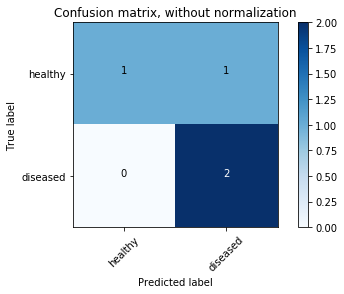

In [21]:
%matplotlib inline


# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["healthy", "diseased"],
                      title='Confusion matrix, without normalization')